In [166]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import f1_score, precision_score, confusion_matrix, accuracy_score, recall_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
import datetime
import os
import csv
import math
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy import stats

np.set_printoptions(linewidth=np.inf)

In [167]:
# Parámetros
inputFolder = "1-input"
processFolder = "2-process"
outputFolder = "3-output"
logsFolder = "4-logs"

inputPretestFolder = inputFolder + r"\1-pretest"
inputPosttestFolder = inputFolder + r"\2-posttest"

dataVisualizationTopLimit = 20

testSize = 0.25
genericRandomState = 0
splitRandomState = 0
samplingStrategy = 0.2
percentileNumberStd = 90
percentileNumberCorrelation = 90

splitsNumber = 12

In [168]:
classifiers = {
  "K vecinos más cercanos": { "name": "K vecinos más cercanos", "acronym": "KNN", "classifier": KNeighborsClassifier(n_neighbors=1, n_jobs=-1) }, 
  "Máquina de vectores de soporte": { "name": "Máquina de vectores de soporte", "acronym": "SVM", "classifier": SVC(random_state=genericRandomState, kernel='poly') }, 
  "Regresión logística": { "name": "Regresión logística", "acronym": "LR", "classifier": LogisticRegression(random_state=genericRandomState, max_iter=200) }, 
  "Naive bayes gaussiano": { "name": "Naive bayes gaussiano", "acronym": "GNB", "classifier": GaussianNB() }, 
  "Árbol de decisión": { "name": "Árbol de decisión", "acronym": "DT", "classifier": DecisionTreeClassifier(random_state=genericRandomState) }, 
  "Bosque aleatorio": { "name": "Bosque aleatorio", "acronym": "RF", "classifier": RandomForestClassifier(random_state=genericRandomState) }, 
}

In [169]:
crossValidators = {
  "K pliegues": { "name": "K pliegues", "acronym": "KP", "validator": KFold(n_splits=splitsNumber, shuffle=True, random_state=genericRandomState) }, 
  "K pliegues estratificados": { "name": "K pliegues estratificados", "acronym": "KPE", "validator": StratifiedKFold(n_splits=splitsNumber, shuffle=True, random_state=genericRandomState) }, 
  "División aleatoria": { "name": "División aleatoria", "acronym": "DA", "validator": ShuffleSplit(n_splits=splitsNumber, test_size=testSize, random_state=genericRandomState) }, 
  "División aleatoria estratificada": { "name": "División aleatoria estratificada", "acronym": "DAE", "validator": StratifiedShuffleSplit(n_splits=splitsNumber, test_size=testSize, random_state=genericRandomState) }, 
}

In [170]:
# Funciones utilitarias de archivos
def readCsvAsDict(filePath, delimiter=",", encoding="utf-8", header=0, dtype={}):
  df = pd.read_csv(filePath, delimiter=delimiter,encoding=encoding, header=header, dtype=dtype)
  df = df.replace(np.nan, '', regex=True)
  data = df.to_dict('records')
  return data

def readCsvAsDf(filePath, delimiter=",", encoding="utf-8", header=0, dtype={}):
  df = pd.read_csv(filePath, delimiter=delimiter,encoding=encoding, header=header, dtype=dtype)
  df = df.replace(np.nan, '', regex=True)
  return df

def writeDictToCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeDfToCsv(data, pathCsv, encoding='utf-8', header=True):
  data.to_csv(path_or_buf = pathCsv, encoding = encoding, header=header, index=False)

def parseTranspose(df):
  transposedDf = df.transpose()
  transposedDf = transposedDf.reset_index()
  transposedDf.columns = transposedDf.iloc[0]
  transposedDf = transposedDf[1:]

  return transposedDf

In [171]:
def preprocessingData(inputPath):
  # Leyendo datos
  df = readCsvAsDf(inputPath)

  # Balanceo de datos: Sobremuestreo aleatorio (oversampling) (1 de cada 5)
  objectiveColumn = "contratado"
  dictResults = dict(df[objectiveColumn].value_counts().sort_index())

  maxKey = max(dictResults, key=dictResults.get)
  maxValue = max(dictResults.values())

  dfClassMaxKey = df[df[objectiveColumn] == maxKey]

  for key, value in dictResults.items():
    if key != maxKey:
      dfClass = df[df[objectiveColumn] == key]
      dfClassSampled = dfClass.sample(int(maxValue * samplingStrategy), random_state=genericRandomState, replace=True)
      dfClassMaxKey = pd.concat([dfClassMaxKey, dfClassSampled],axis=0)

  df = dfClassMaxKey

  # Aleatorizacion del orden de los registros para evitar sesgos(filas)
  df = df.sample(frac = 1, random_state=genericRandomState).reset_index(drop=True)

  # Aplicando OrdinalEncoding a las variables categóricas ordinales()
  encoder = OrdinalEncoder(categories=[[ "Abandonado", "En Curso", "Graduado" ]])
  encoder.fit(df[["estadoUltimoEstudio"]])
  df["estadoUltimoEstudio"] = encoder.transform(df[["estadoUltimoEstudio"]])
  encoder = OrdinalEncoder(categories=[[ "Otro", "Secundario", "Terciario/Tecnico", "Universitario", "Posgrado", "Master", "Doctorado" ]])
  encoder.fit(df[["gradoUltimoEstudio"]])
  df["gradoUltimoEstudio"] = encoder.transform(df[["gradoUltimoEstudio"]])

  # Aplicando OneHotEncoding a las variables categóricas cardinales (transformación a numéricas mediante columnas)
  categoricalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "object" ]
  categoricalCardinalColumns = [columnName for columnName in categoricalColumns if columnName not in [ "estadoUltimoEstudio", "gradoUltimoEstudio" ]]
  for column in categoricalCardinalColumns:
    dummies = pd.get_dummies(df[[column]], prefix=column, dummy_na=True)
    df = pd.concat([df, dummies], axis = 1)
    df = df.drop(columns=[column])

  # Aplicando MinMaxScaler a las variables numéricas (normalización) (esto tambien incluye a lastEducationStatus y lastEducationDegree, ya numéricas)
  # Algunas quedaran en 0.9999, esto porque no todas manejan la misma escala (sin decimales, o solo un decimal)
  numericalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "float64" ]
  for column in numericalColumns:
    df[column] = df[column].fillna(0.0)
  mms = MinMaxScaler()
  df[numericalColumns] = mms.fit_transform(df[numericalColumns])

  # Eliminando columnas con varianza cercana a cero, dejando el 10% de columnas con mayor varianza (variables no afectan en el resultado del modelo)
  df.loc['std'] = df.std()
  stdArray = df.iloc[len(df)-1]
  nthPercentileStd = np.percentile(stdArray, percentileNumberStd)
  df = df.transpose()
  df = df[df["std"]>nthPercentileStd]
  df = df.transpose()
  df = df.drop(['std'], axis=0)

  # Eliminando columnas con correlación cercana a uno, dejando el 90% de columnas con menor correlación
  correlationMatrix = df.corr().abs()
  correlationMatrix[correlationMatrix == 1.0] = 0.0
  maxCorrelationValues = [max(correlationMatrix[column]) for column in correlationMatrix.columns]
  nthPercentileCorrelation = np.percentile(maxCorrelationValues, percentileNumberCorrelation)
  highCorrelationColumns = [column for column in correlationMatrix.columns if max(correlationMatrix[column]) > nthPercentileCorrelation]
  df = df.drop(highCorrelationColumns, axis=1)

  writeDfToCsv(df, os.path.join(processFolder, 'result.csv'))

  return df

In [172]:
def showMetricsCharts(metricsList, context, unit):
  metrics = [
    {"exactitud": "Exactitud"},
    {"precision": "Precisión"},
    {"sensibilidad": "Sensibilidad"},
    {"robustez": "Robustez"},
    {"tiempoPromedio": "Tiempo promedio"},
    {"promedioMetricas": "Promedio de métricas"},
  ]

  for metric in metrics:
    key = list(metric.keys())[0]
    value = metric[key]

    if key != "tiempoPromedio":
      data = {}
      for elem in metricsList:
        data["\n".join(elem[context].split(" "))] = float(elem[key].strip('%')) / 100
      
      keys = list(data.keys())
      values = list(data.values())
        
      fig = plt.figure(figsize = (10, 5))
      
      sortedValues = sorted(values)
      maxValue, secondMaxValue, thirdMaxValue = sortedValues[len(sortedValues)-1], sortedValues[len(sortedValues)-2], sortedValues[len(sortedValues)-3]
      colors = ['tab:red' if (elem == maxValue) else ('tab:blue' if elem == secondMaxValue else ('tab:blue' if elem == thirdMaxValue else 'tab:blue')) for elem in values]
      plt.bar(keys, values, width = 0.4, color=colors)
      
      plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
      plt.ylabel("Porcentaje")
      plt.title("{} por {}".format(value, unit))
      plt.show()
    else:
      data = {}
      for elem in metricsList:
        data["\n".join(elem[context].split(" "))] = float(elem[key])
      
      keys = list(data.keys())
      values = list(data.values())
        
      fig = plt.figure(figsize = (10, 5))
          
      sortedValues = sorted(values, reverse=True)
      maxValue, secondMaxValue, thirdMaxValue = sortedValues[len(sortedValues)-1], sortedValues[len(sortedValues)-2], sortedValues[len(sortedValues)-3]
      colors = ['tab:red' if (elem == maxValue) else ('tab:blue' if elem == secondMaxValue else ('tab:blue' if elem == thirdMaxValue else 'tab:blue')) for elem in values]
      plt.bar(keys, values, width = 0.4, color=colors)
      
      plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, y: "{:.3f}".format(x) + "ms"))
      plt.ylabel("Milisegundos")
      plt.title("{} por {}".format(value, unit))
      plt.show()

In [173]:
def splitData(X, y):
  # Dividiendo los dataframes de entrenamiento y prueba
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state=splitRandomState)

  return X_train, X_test, y_train, y_test

In [174]:
def trainModel(X_train, X_test, y_train, y_test, algorithm):
  # Creación del clasificador
  clf = classifiers[algorithm]["classifier"]

  # Entrenamiento del clasificador
  clf.fit(X_train, y_train)

  # Calculando la predicción del modelo con la data de prueba
  y_pred = clf.predict(X_test)

  return y_test, y_pred

In [175]:
def getMetrics(y_train, y_test, y_pred, startDate, endDate, algorithm, iterationNumber = None, partitionNumber = None, technique = None):
  trainRows = len(y_train)
  testRows = len(y_test)

  # Calculando la exactitud del modelo
  accuracy = accuracy_score(y_test, y_pred)

  # Calculando la precisión del modelo
  precision = precision_score(y_test, y_pred)

  # Calculando la sensibilidad del modelo
  recall = recall_score(y_test, y_pred)

  # Calculando el valor F del modelo (robustez)
  f1Score = f1_score(y_test, y_pred)

  # Calculando el promedio de métricas
  metricsList = [accuracy, precision, recall, f1Score]
  metricsMean = sum(metricsList) / len(metricsList)

  # Calculando el tiempo de ejecución del modelo
  executionTime = (endDate - startDate).total_seconds() * 1000

  # Obteniendo la matriz de confusión
  confussionMatrix = str(confusion_matrix(y_test, y_pred).tolist())
  
  return {
    "sigla": crossValidators[technique]["acronym"],
    "algoritmo": algorithm,
    "iteración": "Iteración {}".format(iterationNumber) if iterationNumber is not None else "Total de datos",
    "particion": "Partición {}".format(partitionNumber) if partitionNumber is not None else "Total de datos",
    "tecnicaValidacion": technique if technique is not None else "Ninguna",
    "registrosEntrenamiento": trainRows,
    "registrosPrueba": testRows,
    "proporcionSobremuestreo": samplingStrategy,
    "matrizConfusion": confussionMatrix,
    "exactitud": "{:.2%}".format(accuracy),
    "precision": "{:.2%}".format(precision),
    "sensibilidad": "{:.2%}".format(recall),
    "robustez": "{:.2%}".format(f1Score),
    "tiempoPromedio": "{:.3f}".format(executionTime/(trainRows + testRows)),
    "promedioMetricas": "{:.2%}".format(metricsMean),
  }

In [176]:
def evaluation(df, algorithm):
  # Creando el arreglo de metricas de cada algoritmo
  techniquesMetricsList = []

  # Lectura de las variables de características y objetivo
  objectiveColumn = "contratado"
  X = df.drop([objectiveColumn], axis=1)
  y = df[objectiveColumn]

  # Iterando por cada validacion cruzada
  for key, value in crossValidators.items():
    for index, (train_index, test_index) in enumerate(value["validator"].split(X, y)):
      X_train, X_test, y_train, y_test = X.iloc[train_index, :], X.iloc[test_index, :], y.iloc[train_index], y.iloc[test_index]

      # Mostrando que partición se usa
      print("Ejecutando para: Técnica {} - Partición {}".format(key, index+1))

      # Inicio de ejecución
      startDate = datetime.datetime.now()

      # Realizar entrenamiento del modelo
      y_test, y_pred = trainModel(X_train, X_test, y_train, y_test, algorithm)

      # Fin de ejecución del modelo
      endDate = datetime.datetime.now()

      # Obteniendo las métricas de la partición del modelo
      partitionMetrics = getMetrics(y_train, y_test, y_pred, startDate, endDate, algorithm, partitionNumber=index+1, technique=key)

      # Añadiendo la métrica de la partición a la lista de métricas
      techniquesMetricsList.append(partitionMetrics)

  # Pasando a dataframe
  techniquesMetricsListDf = pd.DataFrame(techniquesMetricsList)
  techniquesMetricsListTransposedDf = parseTranspose(techniquesMetricsListDf)

  writeDfToCsv(techniquesMetricsListDf, os.path.join(outputFolder, 'result.csv'))
  writeDfToCsv(techniquesMetricsListTransposedDf, os.path.join(outputFolder, 'result_transposed.csv'))

  return techniquesMetricsList

In [177]:
def getSummary(techniquesMetricsList, context):
  summary = []
  for key, value in itertools.groupby(techniquesMetricsList, key=lambda x:x[context]):
    copyValue = list(value).copy()
    summary.append({
      "sigla": crossValidators[key]["acronym"],
      "tecnicaValidacion": key,
      "exactitud": "{:.2%}".format(sum(float(elem["exactitud"].strip('%')) / 100 for elem in copyValue) / len(copyValue)),
      "precision": "{:.2%}".format(sum(float(elem["precision"].strip('%')) / 100 for elem in copyValue) / len(copyValue)),
      "sensibilidad": "{:.2%}".format(sum(float(elem["sensibilidad"].strip('%')) / 100 for elem in copyValue) / len(copyValue)),
      "robustez": "{:.2%}".format(sum(float(elem["robustez"].strip('%')) / 100 for elem in copyValue) / len(copyValue)),
      "tiempoPromedio": "{:.3f}".format(sum(float(elem["tiempoPromedio"]) for elem in copyValue) / len(copyValue)),
      "promedioMetricas": "{:.2%}".format(sum(float(elem["promedioMetricas"].strip('%')) / 100 for elem in copyValue) / len(copyValue)),
    })

  return summary

In [178]:
def showHistogram(data):
  mu, std = stats.norm.fit(data) 

  plt.hist(data, bins=9, color="tab:blue", ec="black")
  #plt.hist(preTestValues, color='lightgreen', ec='black', bins=10)
  #sns.distplot(data, fit=stats.norm, kde=False, hist=True, color='blue', bins=5)

  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p = stats.norm.pdf(x, mu, std)*(xmax - xmin)*4

  plt.plot(x, p, 'k')

  plt.show()

In [179]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))

  # Obteniendo pretest y postest
  print("Obteniendo pretest y postest")
  preTest = readCsvAsDf(os.path.join(inputPretestFolder, 'result.csv'))
  postTest = readCsvAsDf(os.path.join(inputPosttestFolder, 'result.csv'))

  columns = ["exactitud", "precision", "sensibilidad", "robustez", "tiempoPromedio"]

  for column in columns:
    print("{}".format(column))

    preTestValues = preTest[column].to_numpy()

    showHistogram(preTestValues)
    
    postTestValues = postTest[column].to_numpy()

    showHistogram(postTestValues)

    """_, preTestPValue = stats.shapiro(preTestValues)
    print(preTestPValue)
    _, postTestPValue = stats.shapiro(postTestValues)
    print(postTestPValue)
    if (preTestPValue > 0.05 and postTestPValue > 0.05):
      print("Ambas distribuciones son normales, se usará la prueba t student")
      _, comparePValue = stats.ttest_ind(preTestValues, postTestValues)
      print(comparePValue)
    else:
      print("Al menos una distribución es no normal, se usará la prueba de wilcoxon")
      _, comparePValue = stats.wilcoxon(preTestValues, postTestValues)
      print(comparePValue)"""

    print()

  # Tiempo promedio
  # Primer pvalue: 0.6839864253997803
  # Segundo pvalue: 0.03948163986206055

  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

Inicio: 2023-07-05 20:49:24.900020
Obteniendo pretest y postest
exactitud


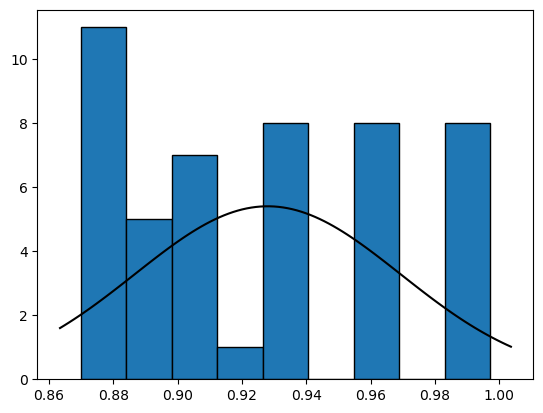

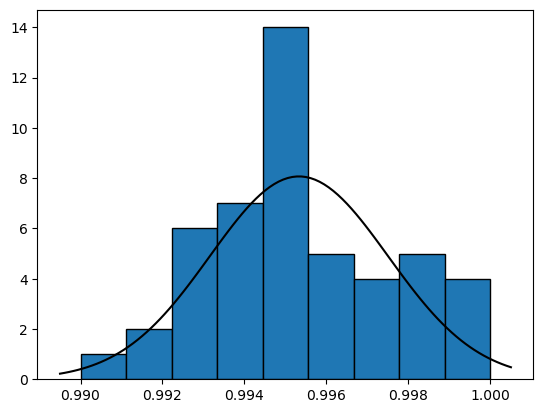


precision


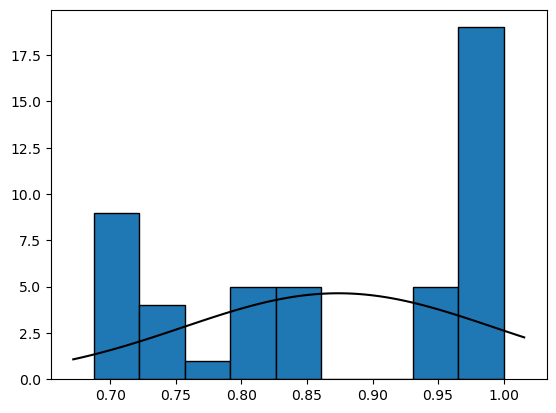

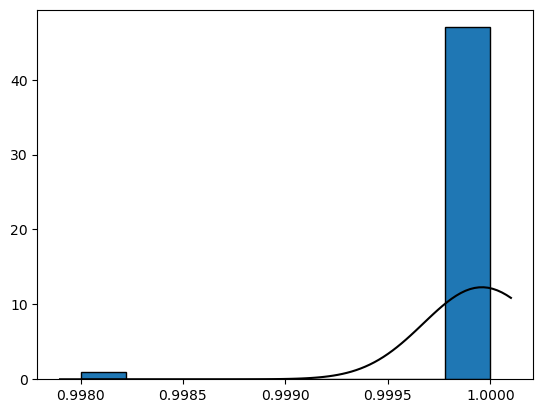


sensibilidad


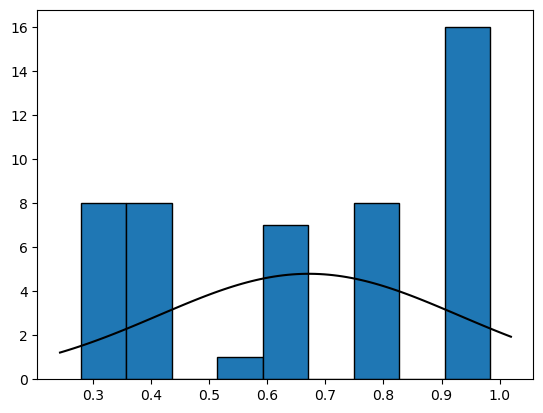

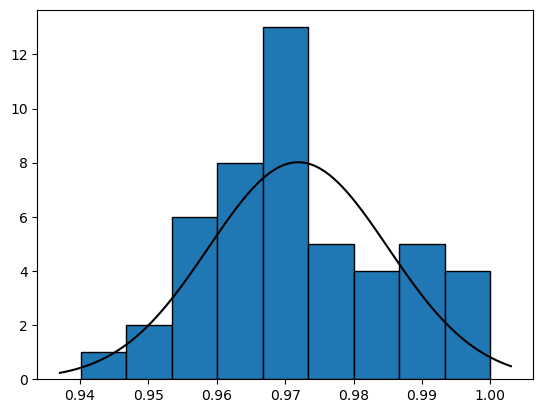


robustez


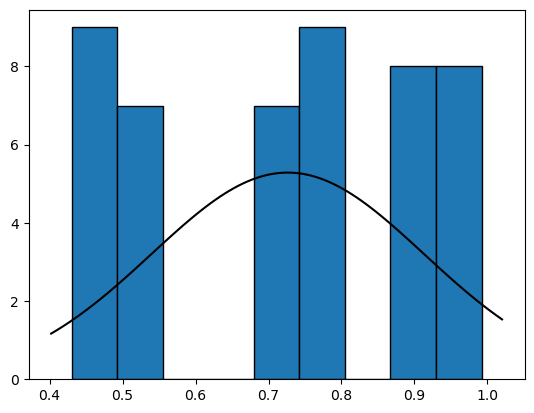

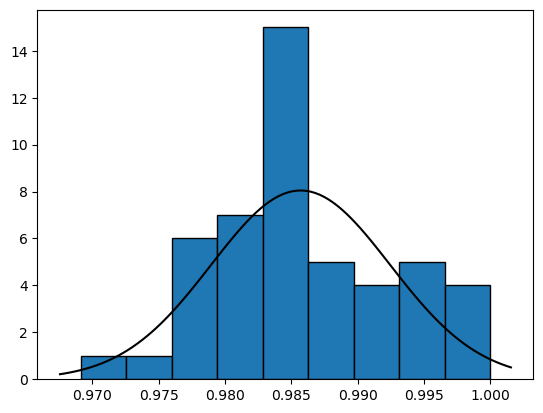


tiempoPromedio


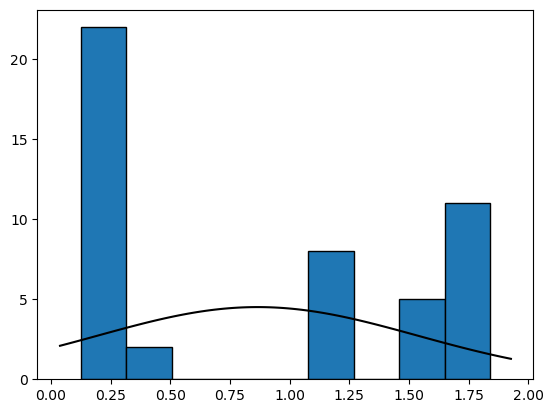

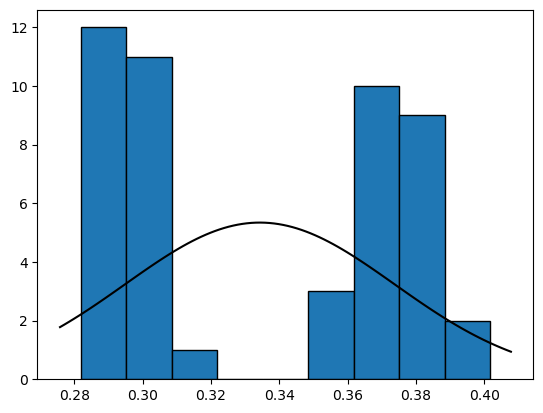


Fin: 2023-07-05 20:49:25.734365
Tiempo: 0:00:00.834345


In [180]:
if __name__ == "__main__":
  main()